In [2]:
import numpy as np
import pyqsp 
from tqdm import tqdm
import json

from maxtrix_inversion_qsvt import MatrixInversionQSVT, QuantumSolverQSVT
from helpers import *

import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update(
    {
        "xtick.direction": "in",
        "ytick.direction": "out",
        "ytick.right": False,
        "xtick.top": False,
        "ytick.left": True,
        "xtick.bottom": False,
        "figure.facecolor": "1",
        "savefig.facecolor": "1",
        "savefig.dpi": 600,
        "figure.dpi": 600,
        "savefig.bbox": "tight",
        "font.size": 7,
        "font.family": "serif",
        "lines.markersize": 4,
        "lines.linewidth": 1,
        'axes.axisbelow' : True
    }
)

# Define colors with names
colors = {
    "red": "#D22B2B",
    "blue": "#377eb8",
    "green": "#4daf4a",
    "purple": "#702963",
    "orange": "#ff7f00",
    "yellow": "#d1b43f",
    "brown": "#a65628",
    "pink": "#f781bf",
    "grey": "#999999",
    "dark grey": "#5b5b5b",
    "black": "#000000",
    "white": "#ffffff"
}

# Golden ratio
figure_size_x = 6.0462
figure_size_y = figure_size_x/1.618

# Approximate polynomial

In [4]:
# Code taken from https://github.com/ichuang/pyqsp

pg = pyqsp.poly.PolyOneOverX()

# Underlying parameters of inverse approximation.
kappa=3
epsilon=0.01
pcoefs, scale = pg.generate(kappa=kappa, epsilon=epsilon, chebyshev_basis=True, return_scale=True)

# Generate anonymous approximation and ideal function for scaled reciprocal.
inv_fun = lambda x: np.polynomial.chebyshev.chebval(x, pcoefs)
ideal_fun = lambda x: scale*np.reciprocal(x)

poly = pyqsp.angle_sequence.Chebyshev(pcoefs) # Chebyshev decomposition of 1/x
phases = np.array(pyqsp.angle_sequence.QuantumSignalProcessingPhases(poly, signal_operator="Wx", measurement="x")) # QSP phases in the Wx convention

npts = 400
full_range = np.linspace(-1., 1., npts)
D_min = np.linspace(-1., -1/kappa/10, npts//2) 
D_plus = np.linspace(1/kappa/10, 1., npts//2)

# Compute QSP response function directly according to method and convention.
qspr = pyqsp.response.ComputeQSPResponse(full_range,
                                         phases,
                                         signal_operator="Wx",
                                         measurement="x",
                                         sym_qsp=True)

# Generate total response function.
pdat = qspr['pdat']

# Grab the Re and Im parts of QSP unitary top-left matrix element.
re_vals = np.real(pdat)
im_vals = np.imag(pdat)

b=51, j0=22
[PolyOneOverX] minimum [-4.58579384] is at [-0.15726745]: normalizing


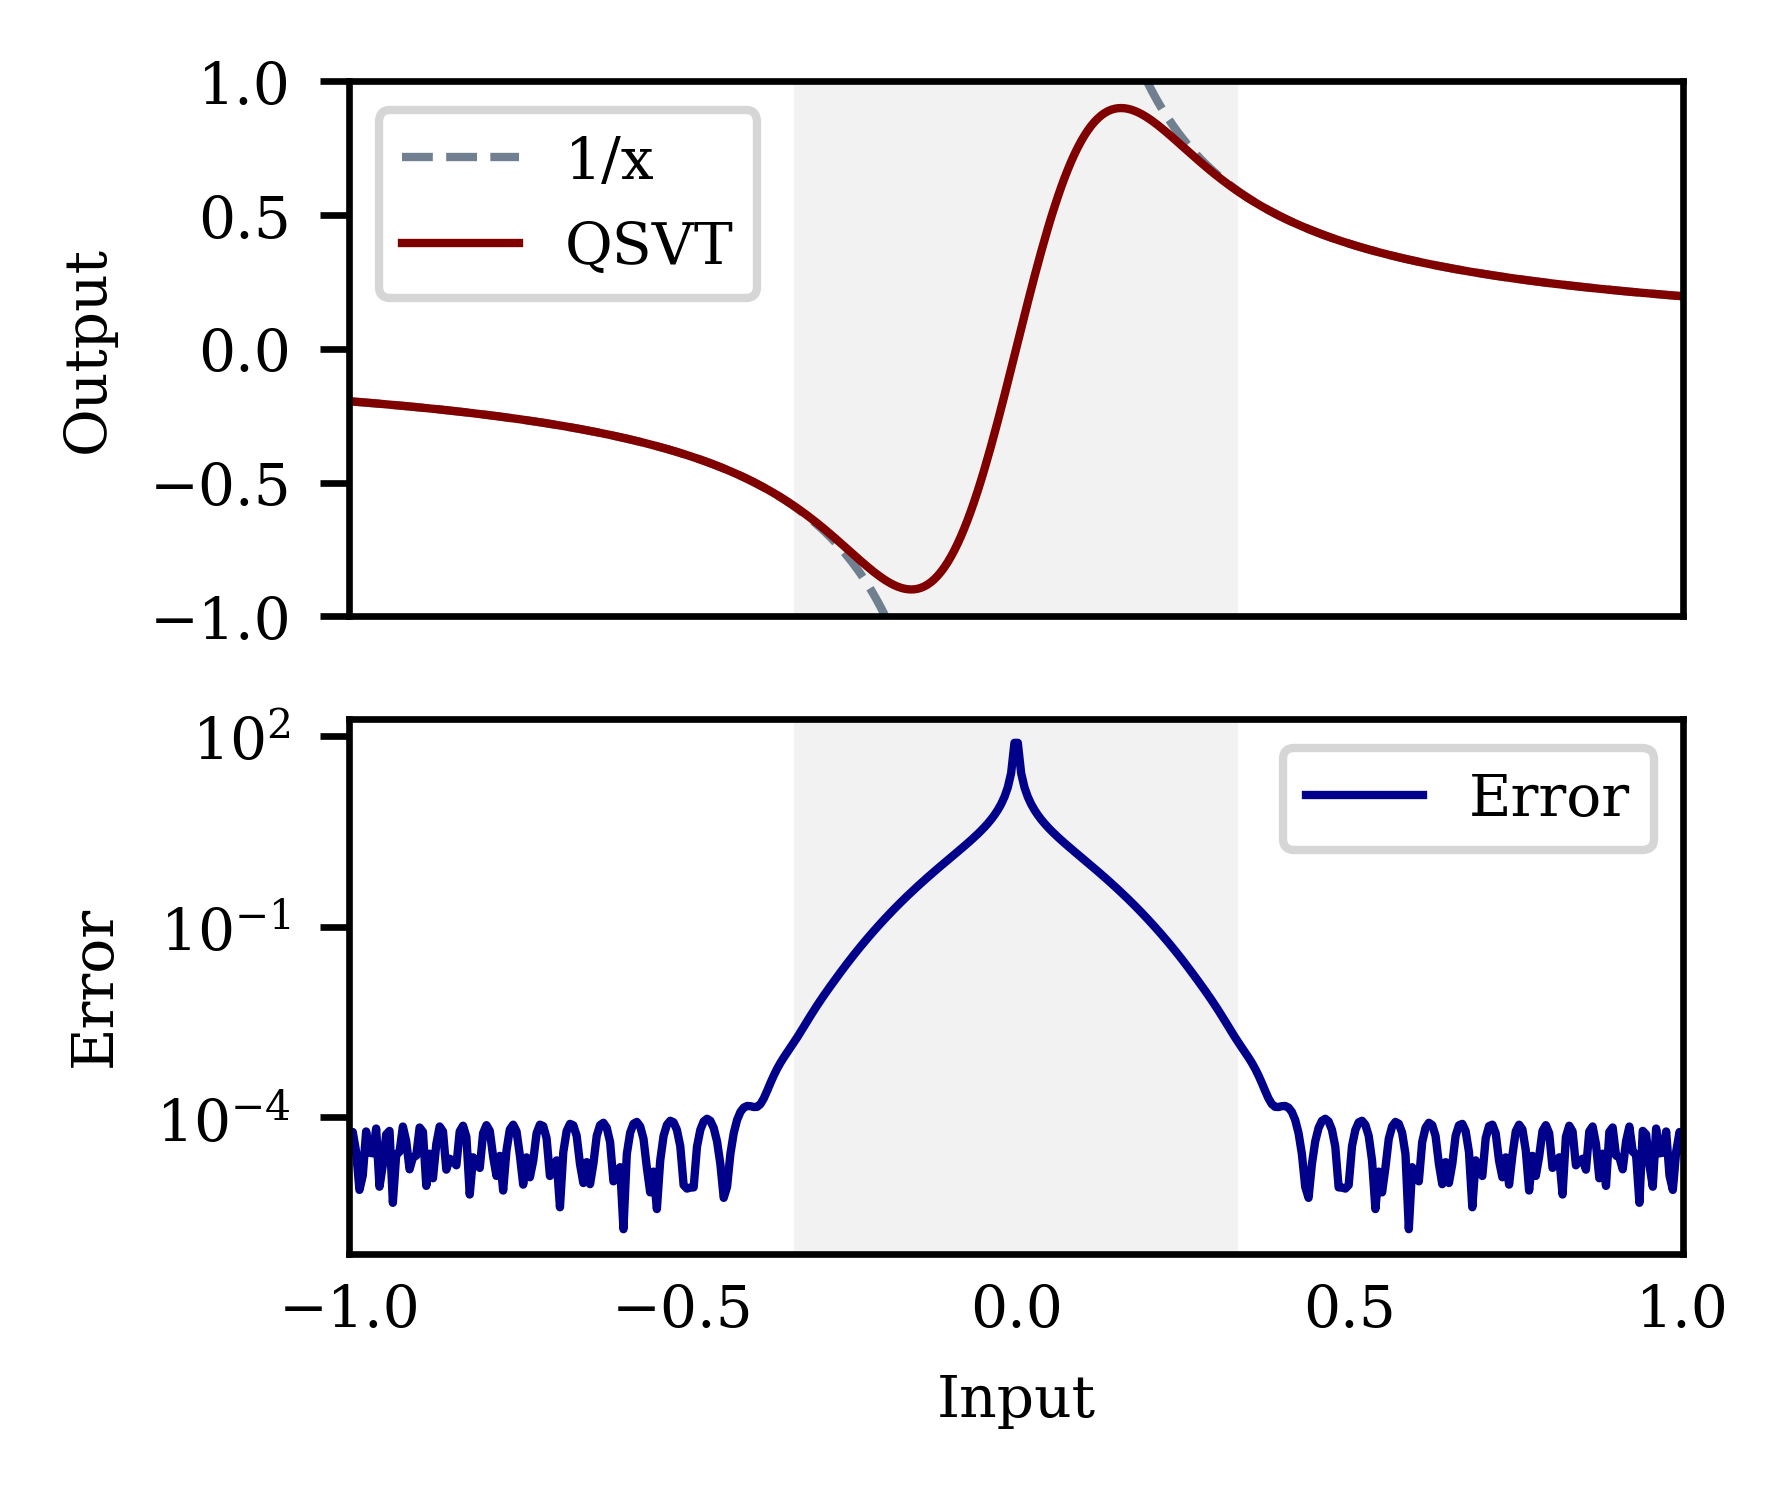

In [5]:
# Define the figure and axes
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(figure_size_x/2, figure_size_y/1.5))

# First plot
axs[0].plot(D_min, ideal_fun(D_min), '--', color='slategrey', label='1/x')
axs[0].plot(D_plus, ideal_fun(D_plus), '--', color='slategrey')
axs[0].plot(full_range, re_vals, color='maroon', label='QSVT')
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_ylabel('Output')
axs[0].axvspan(-1.0/kappa, 1/kappa, alpha=0.1, color='gray', lw=0)
axs[0].legend()

# Second plot
error = np.abs(ideal_fun(full_range) - re_vals)
axs[1].plot(full_range, error, color='darkblue', label='Error')
axs[1].set_yscale('log')
axs[1].set_xlabel('Input')
axs[1].set_ylabel('Error')
axs[1].axvspan(-1.0/kappa, 1/kappa, alpha=0.1, color='gray', lw=0)
axs[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

fig.savefig("qsvt_plot.png", dpi=600)

# Condition number scaling

In [6]:
# Load results from JSON
with open("results_time.json", "r") as json_file:
    loaded_results_time = json.load(json_file)

N_time_list = [2, 3, 4, 5, 6, 7]
kappas_time = loaded_results_time["kappas_time"]
F_norms_time = loaded_results_time["F_norms_time"]
dims_time = loaded_results_time["dims_time"]

In [7]:
# Load results from JSON
with open("results_gp.json", "r") as json_file:
    loaded_results_gp = json.load(json_file)

N_grid_list = [3,4,5,6]
kappas_gp = loaded_results_gp["kappas_gp"]
F_norms_gp = loaded_results_gp["F_norms_gp"]
dims_gp = loaded_results_gp["dims_gp"]

# Depth Scaling

In [8]:
# Generate data for kappa plot
kappas = np.linspace(1, 10, 10)
depths_kappas = []

for kappa in kappas:
    pcoefs, scale = pg.generate(kappa=kappa, epsilon=1e-1, chebyshev_basis=True, return_scale=True)
    poly = pyqsp.angle_sequence.Chebyshev(pcoefs)
    phases = np.array(pyqsp.angle_sequence.QuantumSignalProcessingPhases(poly, signal_operator="Wx", measurement="x"))
    depths_kappas.append(len(phases))

b=2, j0=2
[PolyOneOverX] minimum [-1.088] is at [-0.8]: normalizing
b=11, j0=8
[PolyOneOverX] minimum [-2.17971299] is at [-0.34096123]: normalizing
b=30, j0=14
[PolyOneOverX] minimum [-3.53259398] is at [-0.20533021]: normalizing
b=59, j0=21
[PolyOneOverX] minimum [-4.92820307] is at [-0.14617826]: normalizing
b=97, j0=28
[PolyOneOverX] minimum [-6.3057238] is at [-0.11392906]: normalizing
b=147, j0=35
[PolyOneOverX] minimum [-7.75401864] is at [-0.09251427]: normalizing
b=208, j0=43
[PolyOneOverX] minimum [-9.21778775] is at [-0.07775862]: normalizing
b=280, j0=51
[PolyOneOverX] minimum [-10.69067105] is at [-0.06701114]: normalizing
b=364, j0=59
[PolyOneOverX] minimum [-12.18607907] is at [-0.05876777]: normalizing
b=460, j0=67
[PolyOneOverX] minimum [-13.69663504] is at [-0.05227402]: normalizing


<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\k'
<>:16: SyntaxWarning: invalid escape sequence '\k'
<>:19: SyntaxWarning: invalid escape sequence '\k'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\k'
<>:16: SyntaxWarning: invalid escape sequence '\k'
<>:19: SyntaxWarning: invalid escape sequence '\k'
C:\Users\ivash\AppData\Local\Temp\ipykernel_6236\1047743162.py:8: SyntaxWarning: invalid escape sequence '\p'
  axes[0].plot(kappas, depths_kappas, linestyle='-', alpha=0.3, color='gray', label='Depth $\propto$ $\kappa\log{\kappa}$')
C:\Users\ivash\AppData\Local\Temp\ipykernel_6236\1047743162.py:10: SyntaxWarning: invalid escape sequence '\k'
  axes[0].set_xlabel('Condition number ($\kappa$)')
C:\Users\ivash\AppData\Local\Temp\ipykernel_6236\1047743162.py:16: SyntaxWarning: invalid escape sequence '\k'
  axes[1].plot(N_time_list[:], kappas_time[:], linestyle='-', alpha=0.3, color='gray',

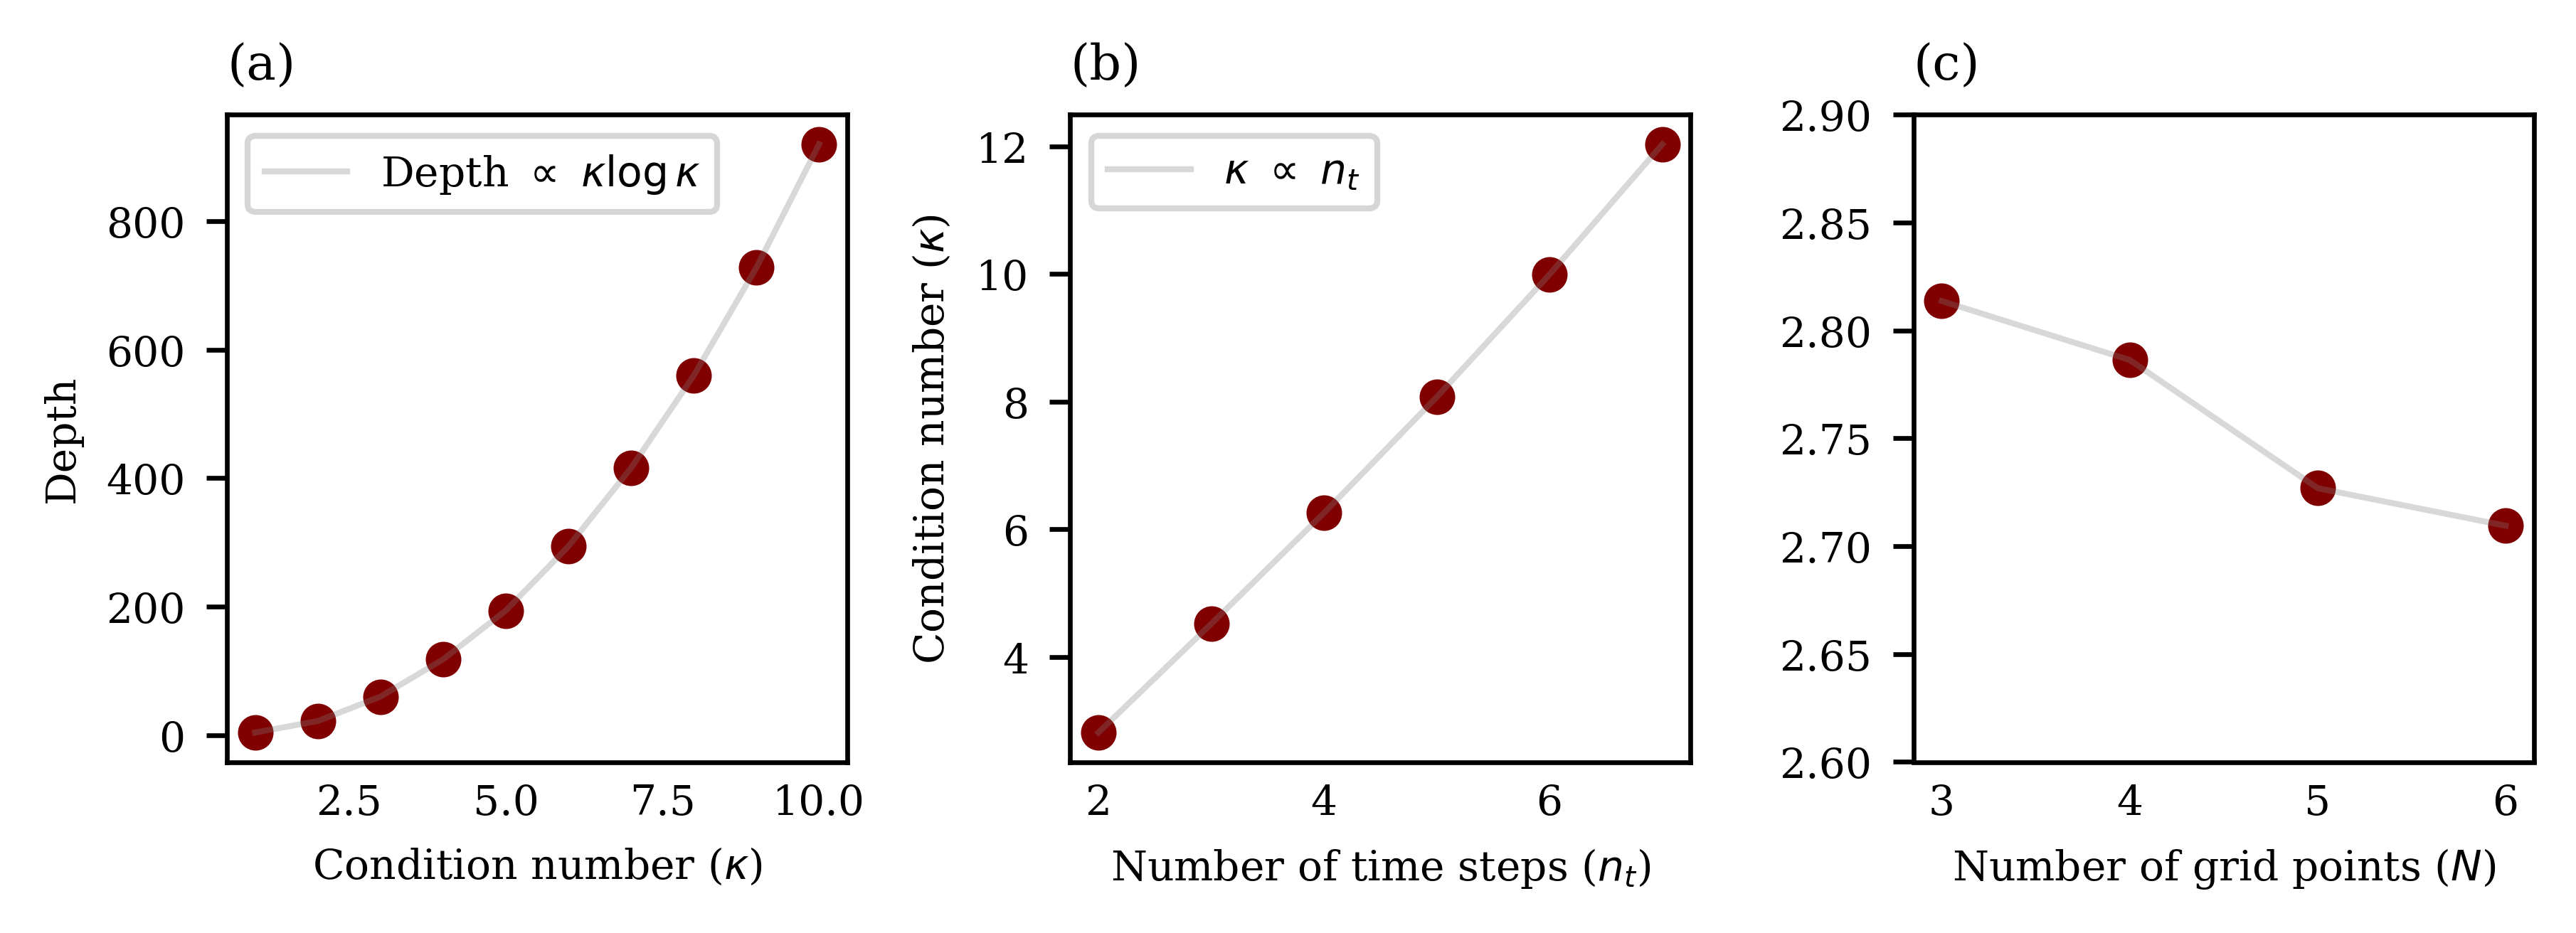

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define figure size
fig, axes = plt.subplots(1, 3, figsize=(figure_size_x, figure_size_y/1.7))  # Now 3 subplots in a row

# Subplot 0: Kappas vs. Depths
axes[0].plot(kappas, depths_kappas, linestyle='-', alpha=0.3, color='gray', label='Depth $\propto$ $\kappa\log{\kappa}$')
axes[0].scatter(kappas, depths_kappas, color='maroon', s=25)
axes[0].set_xlabel('Condition number ($\kappa$)')
axes[0].set_ylabel('Depth')
axes[0].legend()
axes[0].set_title('(a)', loc='left')

# Subplot 1: Epsilons vs. Depths
axes[1].plot(N_time_list[:], kappas_time[:], linestyle='-', alpha=0.3, color='gray', label='$\kappa$ $\propto$ $n_t$')
axes[1].scatter(N_time_list[:], kappas_time[:], color='maroon', s=25)
axes[1].set_xlabel('Number of time steps ($n_t$)')
axes[1].set_ylabel('Condition number ($\kappa$)')
axes[1].legend()
axes[1].set_title('(b)', loc='left')

# Subplot 2: Kappas vs. Grid Points
axes[2].plot(N_grid_list[:], kappas_gp[:], linestyle='-', alpha=0.3, color='gray')
axes[2].scatter(N_grid_list[:], kappas_gp[:], color='maroon', s=25)
axes[2].set_xlabel('Number of grid points ($N$)')
axes[2].set_ylim(2.6, 2.9)
axes[2].set_title('(c)', loc='left')

# Adjust layout for readability
fig.tight_layout()

# Display the plots
plt.show()

fig.savefig("qsvt_scaling.png", dpi=600)


# Sparsity Pattern

In [10]:
Lin_Euler_Matrix = np.load('Lin_Euler_Matrix.npy')
phi = np.load('phi.npy')
x = np.load('x.npy')

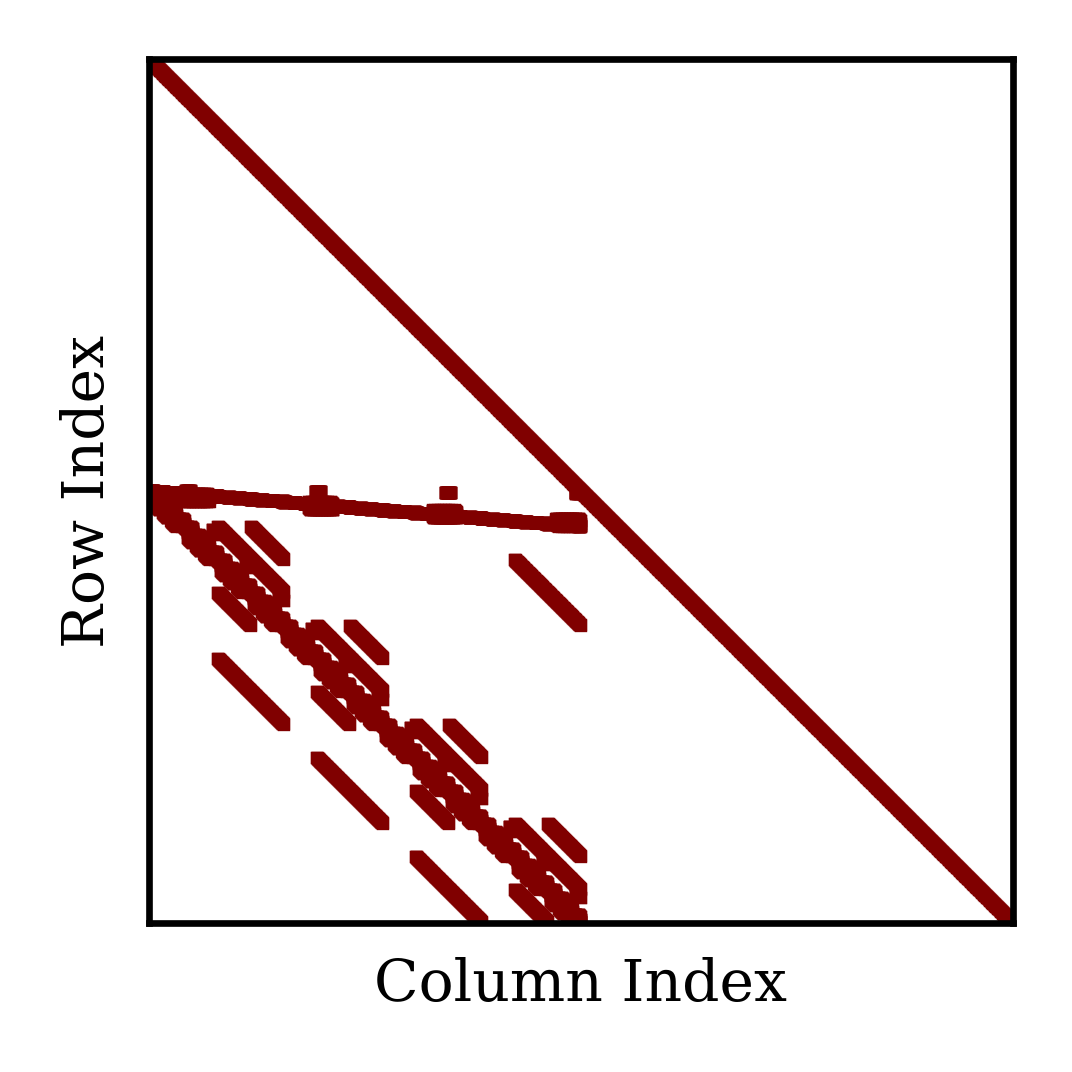

In [11]:
# Calculate sparsity
matrix = Lin_Euler_Matrix
total_elements = matrix.size
nonzero_elements = np.count_nonzero(matrix)
zero_elements = total_elements - nonzero_elements
sparsity = zero_elements / total_elements

fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))
plt.spy(matrix, markersize=0.5, color='maroon')

plt.xlabel("Column Index")
plt.ylabel("Row Index")

plt.xticks([])
plt.yticks([])
plt.show()

fig.savefig("sparsity.png", dpi=600)